# Задание
* Выполнить кластеризацию своего набора данных, считая, что метки кластеров неизвестны.
* Сравнить результаты кластеризации (метки кластеров и реальные метки классов).
* Использовать алгоритмы: k-means, fcm, DBSCAN.
* Оценить качество кластеризации по индексу кластерного силуэта. Определить оптимальное число кластеров (рассмотреть число кластеров от 2 до 10).
* Выбрать лучший алгоритм для своего набора данных.
* Выполнить визуализацию с помощью t-sne и UMAP (при различных сочетаниях значений их параметров): изобразить объекты разных кластеров разным цветом (разным маркерами). Отметить центры кластеров (если алгоритм их вычисляет).

## Подготовка данных
Импортируем необходимые библиотеки

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import csv
import pandas as pd
import numpy as np
import warnings
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import DBSCAN
import umap
from fcmeans import FCM
%matplotlib inline
sns.set_style("white")
warnings.filterwarnings("ignore")

Загружаем и подготавливаем датасет.

In [41]:
data = pd.read_csv('./Data/College_Data.csv')

x = data.drop(['Unnamed: 0', 'Private'], axis=1)
y = data['Private']

for (colName, colData) in x.iteritems():
    x[colName] = x[colName].astype(float)
    x[colName] = x[colName].fillna(x[colName].mean())
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)

## Метод K-Means
### Подбор оптимального числа кластеров
Используемые метки:
* **Гомогенность (homo)** - измеряет насколько каждый кластер состоит из объектов одного класса. Величина принимает значения в диапазоне от 0 до 1, и большие значения соответствуют более точной кластеризации
* **Полнота (comp)** - измеряет насколько объекты одного класса относятся к одному кластеру.
* **V-мера (v-meas)** - является средним гармоническим между гомогенностью и полнотой.
* **Индекс AMI (adj_mutual)** - аналогично ARI определяется индекс AMI. Он принимает значения от 0 до 1 - значения, близкие к нулю, говорят о независимости разбиений, а близкие к единице - об их схожести.
* **Индекс ARI (adj_rand)** - выражает схожесть двух разных кластеризаций одной и той же выборки. Данный индекс принимает значения в диапазоне от -1 до 1 - отрицательные значения говорят о "независимости" разбиений; значения, близкие к нулю, - случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи.
* **Силуэт (silh)** - данный коэффициент не предполагает знания истинных меток объектов и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку. Чем выше значение силуэта - тем лучше результаты кластеризации

In [42]:
metric_dict = {'homo': [], 'comp': [], 'v-meas': [], 'adj_rand': [], 'silh': [], 'adj_mutual': []}
for i in range(2, 11):
    km_model = KMeans(n_clusters=3)
    km_model.fit(x)
    metric_dict['homo'].append(metrics.homogeneity_score(y, km_model.labels_))
    metric_dict['comp'].append(metrics.completeness_score(y, km_model.labels_))
    metric_dict['v-meas'].append(metrics.v_measure_score(y, km_model.labels_))
    metric_dict['adj_mutual'].append(metrics.adjusted_mutual_info_score(y, km_model.labels_))
    metric_dict['adj_rand'].append(metrics.adjusted_rand_score(y, km_model.labels_))
    metric_dict['silh'].append(metrics.silhouette_score(x, km_model.labels_, sample_size=1000))

###  Создание модели с оптимальным числом кластеров

In [43]:
km_model = KMeans(n_clusters=2)
km_model.fit(x)
centroids = km_model.cluster_centers_
hs = metrics.homogeneity_score(y, km_model.labels_)
cs = metrics.completeness_score(y, km_model.labels_)
ms = metrics.v_measure_score(y, km_model.labels_)
ari = metrics.adjusted_rand_score(y, km_model.labels_)
ami = metrics.adjusted_mutual_info_score(y, km_model.labels_)
ss = metrics.silhouette_score(x, km_model.labels_, sample_size=1000)
print(f"Homogeneity: {hs}")
print(f"Completeness: {cs}")
print(f"V-measure: {ms}")
print(f"Adjusted Rand-Index: {ari}")
print(f"Adjusted Mutual Info Score: {ami}")
print(f"Silhouette Coefficient: {ss}")

Homogeneity: 0.104510353831783
Completeness: 0.15193372538313987
V-measure: 0.12383711448814684
Adjusted Rand-Index: 0.22700271229120828
Adjusted Mutual Info Score: 0.12268826188214105
Silhouette Coefficient: 0.5599267817640777


### Преобразование исходной выборки для визуализации метода алгоритмами t-SNE и UMAP

In [44]:
c = pd.DataFrame(centroids)
xc = pd.concat([x, c], ignore_index=True)
res = ['centroids' for i in range(2)]
rs = pd.DataFrame(res)
yc = pd.concat([y, rs], ignore_index=True)
y1 = pd.DataFrame(km_model.labels_)

### Визуализация полученных результатов с помощью алгоритма t-SNE
Построим два рисунка разбиения на кластеры - на одном цвета точек будут соответствовать классам, указанным в выборке, а на другом - выставленным кластеризатором.

In [45]:
x_embedded = TSNE(n_components=2, verbose=1, perplexity=40, 
                  early_exaggeration=12, metric='euclidean',
                 learning_rate=100, n_iter=2000).fit_transform(xc)

x_df = pd.DataFrame()
x_df['tsne-2d-one'] = x_embedded[:155,0]
x_df['tsne-2d-two'] = x_embedded[:155,1]
x_df['yc'] = yc[:155]

c_df = pd.DataFrame()
c_df['tsne-centroids-x-one'] = x_embedded[155:, 0]
c_df['tsne-centroids-x-two'] = x_embedded[155:, 1]
c_df['tsne-centroids-y'] = yc[155:]

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="yc", 
                palette=sns.color_palette("bright", 2), 
                data=x_df, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-centroids-x-one", y="tsne-centroids-x-two", 
                hue="tsne-centroids-y", data=c_df, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [39]:
x1_df = pd.DataFrame()
x1_df['tsne-2d-one'] = x_embedded[:155,0]
x1_df['tsne-2d-two'] = x_embedded[:155,1]
x1_df['y1'] = y1

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 3), 
                data=x1_df, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-centroids-x-one", y="tsne-centroids-x-two", 
                hue="tsne-centroids-y", data=c_df, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

NameError: name 'x_embedded' is not defined

### Визуализация полученных результатов с помощью алгоритма UMAP
Так же как и в случае с t-SNE, построим два рисунка разбиения на кластеры - на одном цвета точек будут соответствовать классам, указанным в выборке, а на другом - выставленным кластеризатором.

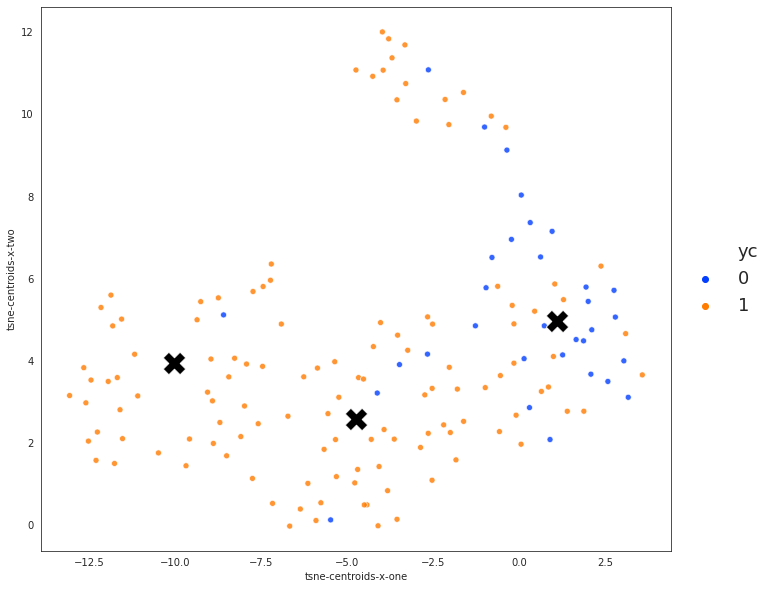

In [20]:
x_embedded_k = umap.UMAP(n_neighbors=5, min_dist=0.8, metric='euclidean').fit_transform(xc)
x_df_k = pd.DataFrame()
x_df_k['tsne-2d-one'] = x_embedded_k[:155, 0]
x_df_k['tsne-2d-two'] = x_embedded_k[:155, 1]
x_df_k['yc'] = yc[:155]

c_df_k = pd.DataFrame()
c_df_k['tsne-centroids-x-one'] = x_embedded_k[155:, 0]
c_df_k['tsne-centroids-x-two'] = x_embedded_k[155:, 1]
c_df_k['tsne-centroids-y'] = yc[155:]

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="yc", 
                palette=sns.color_palette("bright", 2), 
                data=x_df_k,legend="full", alpha=0.8)
sns.scatterplot(x="tsne-centroids-x-one", y="tsne-centroids-x-two", 
                hue="tsne-centroids-y", data=c_df_k, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

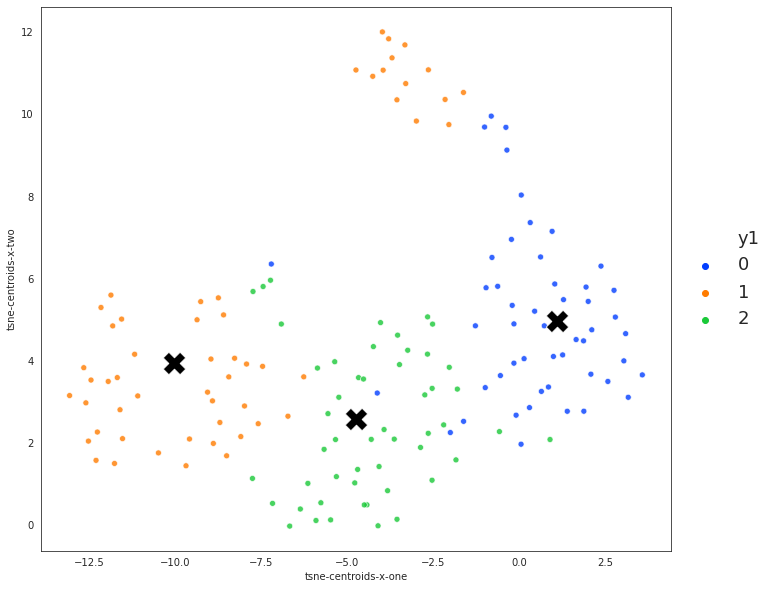

In [21]:
x1_df_k = pd.DataFrame()
x1_df_k['tsne-2d-one'] = x_embedded_k[:155,0]
x1_df_k['tsne-2d-two'] = x_embedded_k[:155,1]
x1_df_k['y1'] = y1

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 3), 
                data=x1_df_k, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-centroids-x-one", y="tsne-centroids-x-two", 
                hue="tsne-centroids-y", data=c_df_k, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

## Метод Fuzzy C-Means (FCM)
### Преобразование исходной выборки с помощью алгоритма t-SNE

In [22]:
x_embedded_1 = TSNE(n_components=2, verbose=1, perplexity=40, 
                  early_exaggeration=12, metric='euclidean',
                 learning_rate=100, n_iter=2000).fit_transform(x)

x_df_1 = pd.DataFrame()
x_df_1['tsne-2d-one'] = x_embedded_1[:,0]
x_df_1['tsne-2d-two'] = x_embedded_1[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 155 samples in 0.000s...
[t-SNE] Computed neighbors for 155 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 155 / 155
[t-SNE] Mean sigma: 0.898091
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.238602
[t-SNE] KL divergence after 750 iterations: 0.439561


### Подбор оптимального числа кластеров
Для из подбора будем использовать те же самые метрики, что и в методе K-Means.

In [23]:
metric_dict_fcm = {'homo': [], 'comp': [], 'v-meas': [], 'adj_rand': [], 'silh': [], 'adj_mutual': []}
for i in range(2, 11):
    fcm_model = FCM(n_clusters=i)
    fcm_model.fit(x_df_1)
    metric_dict_fcm['homo'].append(metrics.homogeneity_score(y, fcm_model.u.argmax(axis=1)))
    metric_dict_fcm['comp'].append(metrics.completeness_score(y, fcm_model.u.argmax(axis=1)))
    metric_dict_fcm['v-meas'].append(metrics.v_measure_score(y, fcm_model.u.argmax(axis=1)))
    metric_dict_fcm['adj_mutual'].append(metrics.adjusted_mutual_info_score(y, fcm_model.u.argmax(axis=1)))
    metric_dict_fcm['adj_rand'].append(metrics.adjusted_rand_score(y, fcm_model.u.argmax(axis=1)))
    metric_dict_fcm['silh'].append(metrics.silhouette_score(x, fcm_model.u.argmax(axis=1), sample_size=1000))

### Построение графиков для метрик

(0.1, 1.0)

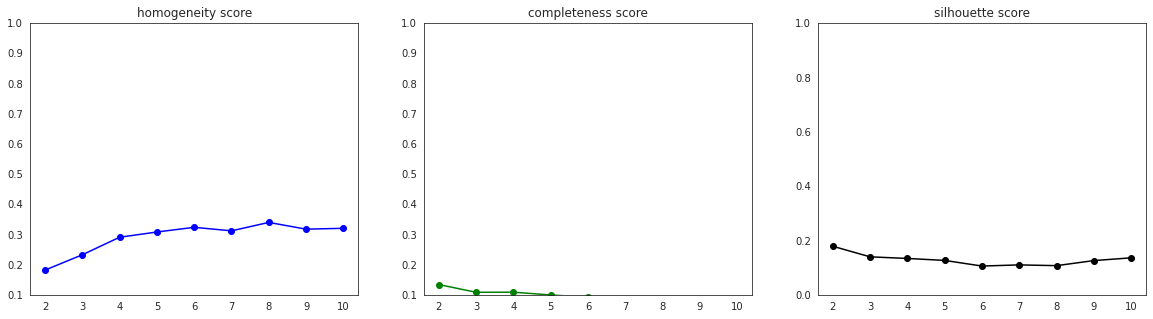

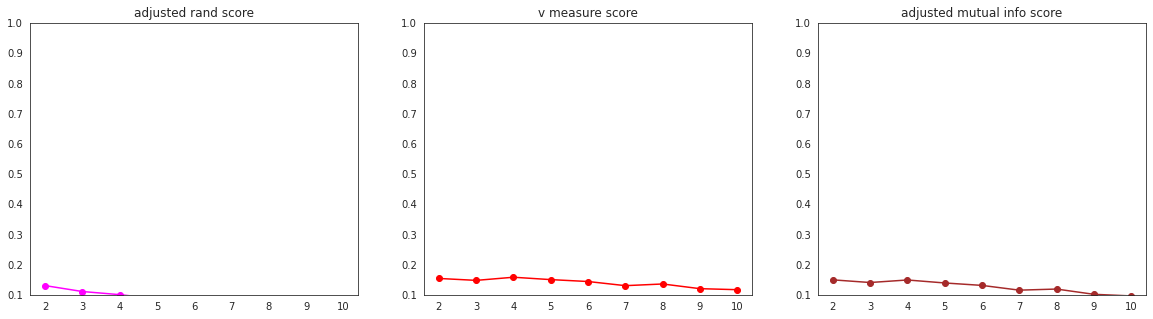

In [24]:
r = [i for i in range(2, 11)]
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("homogeneity score")
plt.plot(r, metric_dict_fcm['homo'], marker='o', color='blue')
ax1.set_ylim([0.1, 1])

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("completeness score")
plt.plot(r, metric_dict_fcm['comp'], marker='o', color='green')
ax2.set_ylim([0.1, 1])

ax3 = plt.subplot(1, 3, 3)
ax3.set_title("silhouette score")
plt.plot(r, metric_dict_fcm['silh'], marker='o', color='black')
ax3.set_ylim([0, 1])

fig = plt.figure(figsize=(20, 5))
ax4 = plt.subplot(1, 3, 1)
ax4.set_title("adjusted rand score")
plt.plot(r, metric_dict_fcm['adj_rand'], marker='o', color='magenta')
ax4.set_ylim([0.1, 1])

ax5 = plt.subplot(1, 3, 2)
ax5.set_title("v measure score")
plt.plot(r, metric_dict_fcm['v-meas'], marker='o', color="red")
ax5.set_ylim([0.1, 1])

ax6 = plt.subplot(1, 3, 3)
ax6.set_title("adjusted mutual info score")
plt.plot(r, metric_dict_fcm['adj_mutual'], marker='o', color='brown')
ax6.set_ylim([0.1, 1])

### Создание модели с оптимальным числом кластеров
Создаем FCM модель с количеством кластеров, равным двум, и выводим значения метрик.

In [25]:
fcm_model = FCM(n_clusters=2)
fcm_model.fit(x_df_1)
centers = fcm_model.centers
hs_1 = metrics.homogeneity_score(y, fcm_model.u.argmax(axis=1))
cs_1 = metrics.completeness_score(y, fcm_model.u.argmax(axis=1))
ms_1 = metrics.v_measure_score(y, fcm_model.u.argmax(axis=1))
ari_1 = metrics.adjusted_rand_score(y, fcm_model.u.argmax(axis=1))
ami_1 = metrics.adjusted_mutual_info_score(y, fcm_model.u.argmax(axis=1))
ss_1 = metrics.silhouette_score(x, fcm_model.u.argmax(axis=1), sample_size=1000)
print(f"Homogeneity: {hs}")
print(f"Completeness: {cs}")
print(f"V-measure: {ms}")
print(f"Adjusted Rand-Index: {ari}")
print(f"Adjusted Mutual Info Score: {ami}")
print(f"Silhouette Coefficient: {ss}")

Homogeneity: 0.2753898835921651
Completeness: 0.12770837631199072
V-measure: 0.17449638653694896
Adjusted Rand-Index: 0.1142178844499296
Adjusted Mutual Info Score: 0.16765842320020313
Silhouette Coefficient: 0.15125939132259625


### Создание датафрейма с центрами кластеров
Чтобы отобразить на графиках полученные центры кластеров, поместим их координаты в отдельный датафрейм и сопоставим им соответствующие метки "centers".

In [26]:
res_fcm = ['centers' for i in range(6)]
rs_fcm = pd.DataFrame(res_fcm)
centers['yc'] = rs_fcm
y1_fcm = pd.DataFrame(fcm_model.u.argmax(axis=1))

### Визуализация полученных результатов
Построим два рисунка разбиения на кластеры - на одном цвета точек будут соответствовать классам, указанным в выборке, а на другом - выставленным кластеризатором.

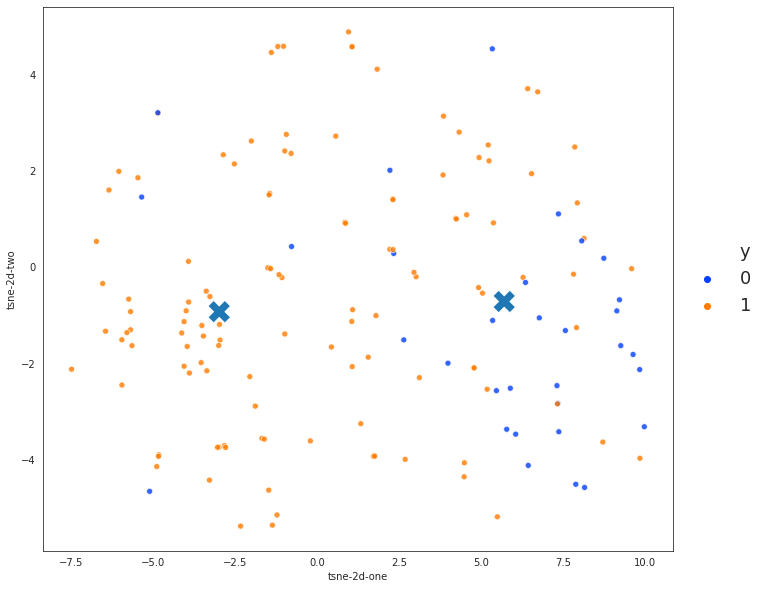

In [27]:
x_df_1['y'] = y.values
fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y", 
                palette=sns.color_palette("bright", 2), 
                data=x_df_1, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", 
                hue="yc", data=centers, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

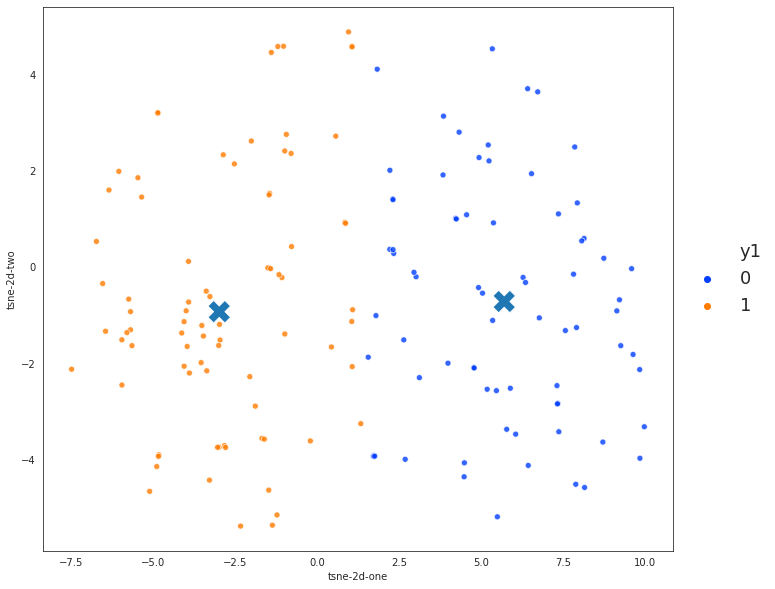

In [28]:
x_df_1['y1'] = y1_fcm
fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 2), 
                data=x_df_1, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", 
                hue="yc", data=centers, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

### Преобразование исходной выборки с помощью алгоритма UMAP

In [29]:
x_embedded_2 = umap.UMAP(n_neighbors=5, min_dist=0.8, metric='euclidean').fit_transform(x)
x_df_2 = pd.DataFrame()
x_df_2['tsne-2d-one'] = x_embedded_2[:, 0]
x_df_2['tsne-2d-two'] = x_embedded_2[:, 1]

### Подбор оптимального числа кластеров

In [30]:
metric_dict_fcm = {'homo': [], 'comp': [], 'v-meas': [], 'adj_rand': [], 'silh': [], 'adj_mutual': []}
for i in range(2, 11):
    fcm_model_1 = FCM(n_clusters=i)
    fcm_model_1.fit(x_df_2)
    metric_dict_fcm['homo'].append(metrics.homogeneity_score(y, fcm_model_1.u.argmax(axis=1)))
    metric_dict_fcm['comp'].append(metrics.completeness_score(y, fcm_model_1.u.argmax(axis=1)))
    metric_dict_fcm['v-meas'].append(metrics.v_measure_score(y, fcm_model_1.u.argmax(axis=1)))
    metric_dict_fcm['adj_mutual'].append(metrics.adjusted_mutual_info_score(y, fcm_model_1.u.argmax(axis=1)))
    metric_dict_fcm['adj_rand'].append(metrics.adjusted_rand_score(y, fcm_model_1.u.argmax(axis=1)))
    metric_dict_fcm['silh'].append(metrics.silhouette_score(x, fcm_model_1.u.argmax(axis=1), sample_size=1000))

### Построение графиков для метрик

(0.1, 1.0)

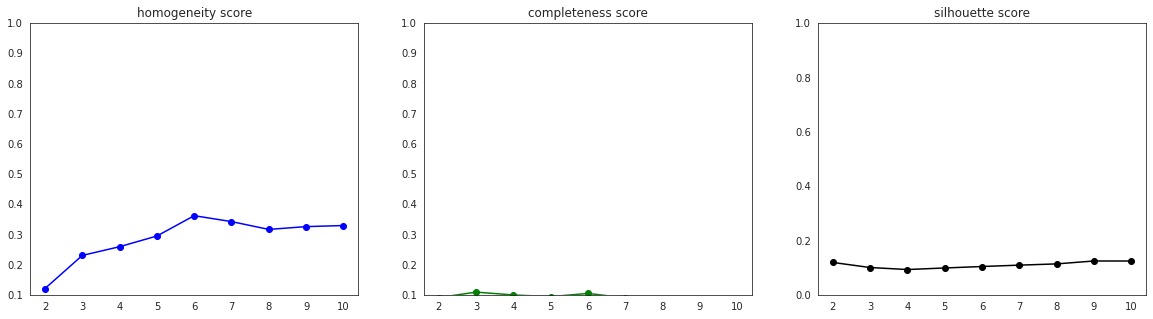

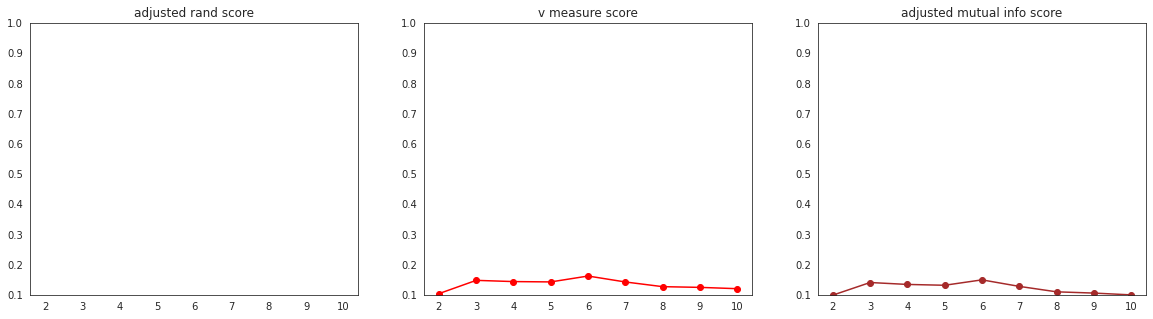

In [31]:
r = [i for i in range(2, 11)]
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("homogeneity score")
plt.plot(r, metric_dict_fcm['homo'], marker='o', color='blue')
ax1.set_ylim([0.1, 1])

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("completeness score")
plt.plot(r, metric_dict_fcm['comp'], marker='o', color='green')
ax2.set_ylim([0.1, 1])

ax3 = plt.subplot(1, 3, 3)
ax3.set_title("silhouette score")
plt.plot(r, metric_dict_fcm['silh'], marker='o', color='black')
ax3.set_ylim([0, 1])

fig = plt.figure(figsize=(20, 5))
ax4 = plt.subplot(1, 3, 1)
ax4.set_title("adjusted rand score")
plt.plot(r, metric_dict_fcm['adj_rand'], marker='o', color='magenta')
ax4.set_ylim([0.1, 1])

ax5 = plt.subplot(1, 3, 2)
ax5.set_title("v measure score")
plt.plot(r, metric_dict_fcm['v-meas'], marker='o', color="red")
ax5.set_ylim([0.1, 1])

ax6 = plt.subplot(1, 3, 3)
ax6.set_title("adjusted mutual info score")
plt.plot(r, metric_dict_fcm['adj_mutual'], marker='o', color='brown')
ax6.set_ylim([0.1, 1])

### Создание модели с оптимальным числом кластеров
Создаем FCM модель с количеством кластеров, равным шести, и выводим значения метрик.

In [32]:
fcm_model_1 = FCM(n_clusters=6)
fcm_model_1.fit(x_df_2)
centers_1 = fcm_model_1.centers

In [33]:
hs_2 = metrics.homogeneity_score(y, fcm_model_1.u.argmax(axis=1))
cs_2 = metrics.completeness_score(y, fcm_model_1.u.argmax(axis=1))
ms_2 = metrics.v_measure_score(y, fcm_model_1.u.argmax(axis=1))
ari_2 = metrics.adjusted_rand_score(y, fcm_model_1.u.argmax(axis=1))
ami_2 = metrics.adjusted_mutual_info_score(y, fcm_model_1.u.argmax(axis=1))
ss_2 = metrics.silhouette_score(x, fcm_model_1.u.argmax(axis=1), sample_size=1000)
print(f"Homogeneity: {hs}")
print(f"Completeness: {cs}")
print(f"V-measure: {ms}")
print(f"Adjusted Rand-Index: {ari}")
print(f"Adjusted Mutual Info Score: {ami}")
print(f"Silhouette Coefficient: {ss}")

Homogeneity: 0.2753898835921651
Completeness: 0.12770837631199072
V-measure: 0.17449638653694896
Adjusted Rand-Index: 0.1142178844499296
Adjusted Mutual Info Score: 0.16765842320020313
Silhouette Coefficient: 0.15125939132259625


### Создание датафрейма с центрами кластеров
Чтобы отобразить на графиках полученные центры кластеров, поместим их координаты в отдельный датафрейм и сопоставим им соответствующие метки "centers".

In [34]:
res_fcm_1 = ['centers' for i in range(6)]
rs_fcm_1 = pd.DataFrame(res_fcm_1)
centers_1['yc'] = rs_fcm_1
y1_fcm_1 = pd.DataFrame(fcm_model_1.u.argmax(axis=1))

### Визуализация полученных результатов
Построим два рисунка разбиения на кластеры - на одном цвета точек будут соответствовать классам, указанным в выборке, а на другом - выставленным кластеризатором.

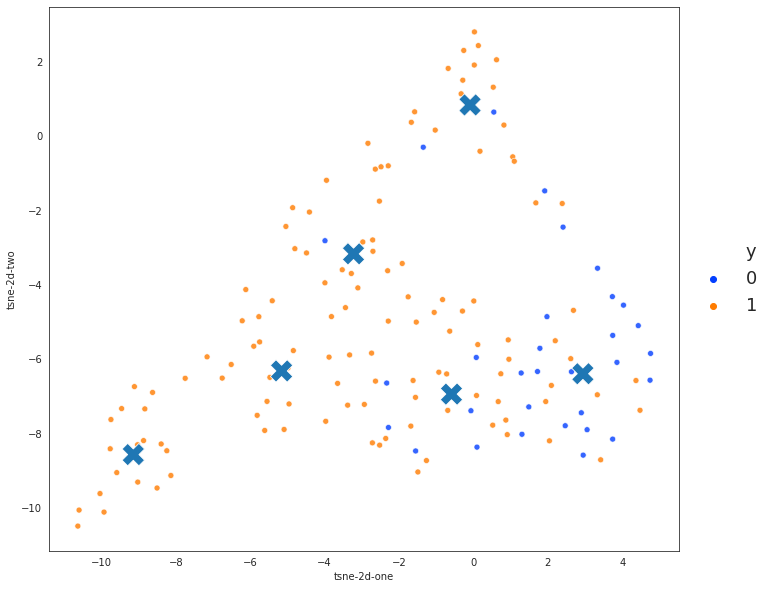

In [35]:
x_df_2['y'] = y.values
fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y", 
                palette=sns.color_palette("bright", 2), 
                data=x_df_2, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", 
                hue="yc", data=centers_1, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

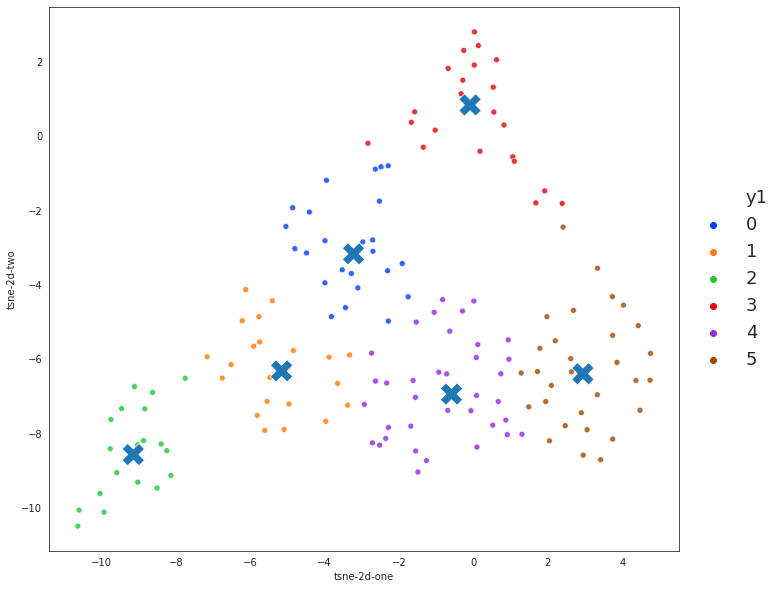

In [36]:
x_df_2['y1'] = y1_fcm_1
fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 6), 
                data=x_df_2, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", 
                hue="yc", data=centers_1, legend=False, 
                alpha=1, marker='X', s=500, color='black')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

## Метод DBSCAN
Данный метод, в отличие от K-Means и FCM, оперирует плотностью данных и не требует указания числа кластеров, на которые нужно разбить выборку - их количество он определит самостоятельно. На вход же ему подаются два других параметра:
* **min_samples** - минимальное число точек в окрестности (минимальное число соседей)
* **eps** - максимальное расстояние между точками

Рассмотрим различные варианты этих параметров и подберем оптимальные.
### Подбор значения параметра min_samples
Минимальное число точек в окрестности будем выбирать в диапазоне от 2 до 11.

In [37]:
metric_dict_dbs = {'homo': [], 'comp': [], 'v-meas': [], 'adj_rand': [], 'silh': [], 'adj_mutual': []}
eps = [i for i in range(2, 11)]
for i in eps:
    dbs_model = DBSCAN(min_samples=i)
    dbs_model.fit(x)
    metric_dict_dbs['homo'].append(metrics.homogeneity_score(y, dbs_model.labels_))
    metric_dict_dbs['comp'].append(metrics.completeness_score(y, dbs_model.labels_))
    metric_dict_dbs['v-meas'].append(metrics.v_measure_score(y, dbs_model.labels_))
    metric_dict_dbs['adj_mutual'].append(metrics.adjusted_mutual_info_score(y, dbs_model.labels_))
    metric_dict_dbs['adj_rand'].append(metrics.adjusted_rand_score(y, dbs_model.labels_))
    metric_dict_dbs['silh'].append(metrics.silhouette_score(x, dbs_model.labels_, sample_size=1000))

### Построение графиков для метрик (параметр min_samples)

(-1.0, 1.0)

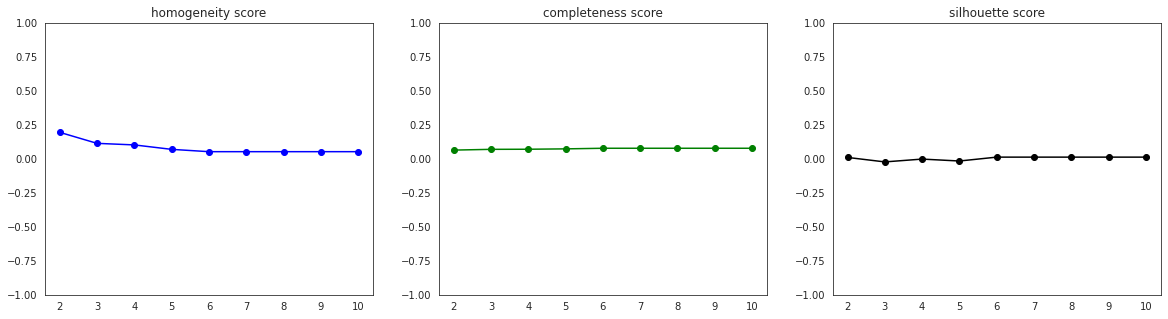

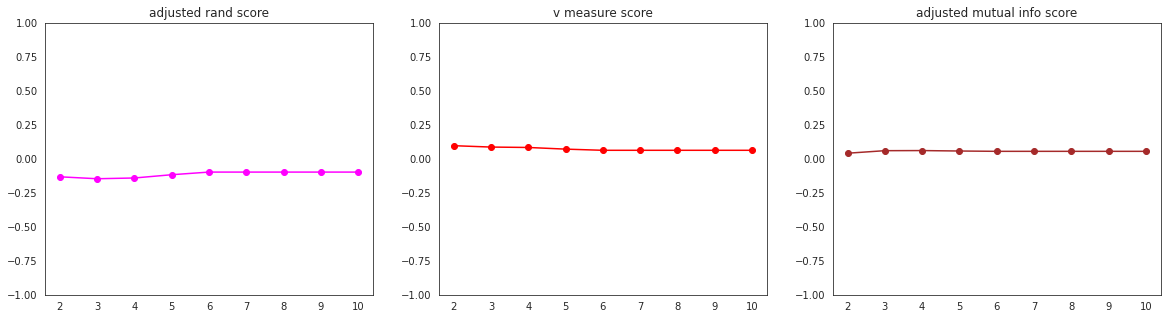

In [38]:
r = [i for i in range(2, 11)]
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("homogeneity score")
plt.plot(r, metric_dict_dbs['homo'], marker='o', color='blue')
ax1.set_ylim([-1, 1])

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("completeness score")
plt.plot(r, metric_dict_dbs['comp'], marker='o', color='green')
ax2.set_ylim([-1, 1])

ax3 = plt.subplot(1, 3, 3)
ax3.set_title("silhouette score")
plt.plot(r, metric_dict_dbs['silh'], marker='o', color='black')
ax3.set_ylim([-1, 1])

fig = plt.figure(figsize=(20, 5))
ax4 = plt.subplot(1, 3, 1)
ax4.set_title("adjusted rand score")
plt.plot(r, metric_dict_dbs['adj_rand'], marker='o', color='magenta')
ax4.set_ylim([-1, 1])

ax5 = plt.subplot(1, 3, 2)
ax5.set_title("v measure score")
plt.plot(r, metric_dict_dbs['v-meas'], marker='o', color="red")
ax5.set_ylim([-1, 1])

ax6 = plt.subplot(1, 3, 3)
ax6.set_title("adjusted mutual info score")
plt.plot(r, metric_dict_dbs['adj_mutual'], marker='o', color='brown')
ax6.set_ylim([-1, 1])

### Подбор значения параметра eps
Максимальное расстояние между точками будем выбирать, исходя из значений, представленных в массиве eps.

In [40]:
metric_dict_dbs = {'homo': [], 'comp': [], 'v-meas': [], 'adj_rand': [], 'adj_mutual': []}
eps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9, 1, 1.5, 2]
for i in eps:
    dbs_model = DBSCAN(eps=i)
    dbs_model.fit(x)
    metric_dict_dbs['homo'].append(metrics.homogeneity_score(y, dbs_model.labels_))
    metric_dict_dbs['comp'].append(metrics.completeness_score(y, dbs_model.labels_))
    metric_dict_dbs['v-meas'].append(metrics.v_measure_score(y, dbs_model.labels_))
    metric_dict_dbs['adj_mutual'].append(metrics.adjusted_mutual_info_score(y, dbs_model.labels_))
    metric_dict_dbs['adj_rand'].append(metrics.adjusted_rand_score(y, dbs_model.labels_))

(-1.0, 1.0)

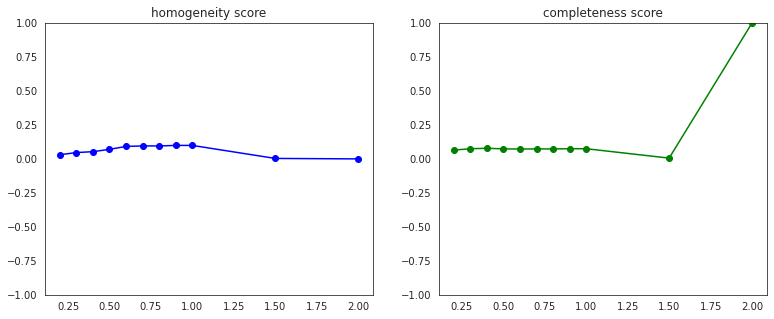

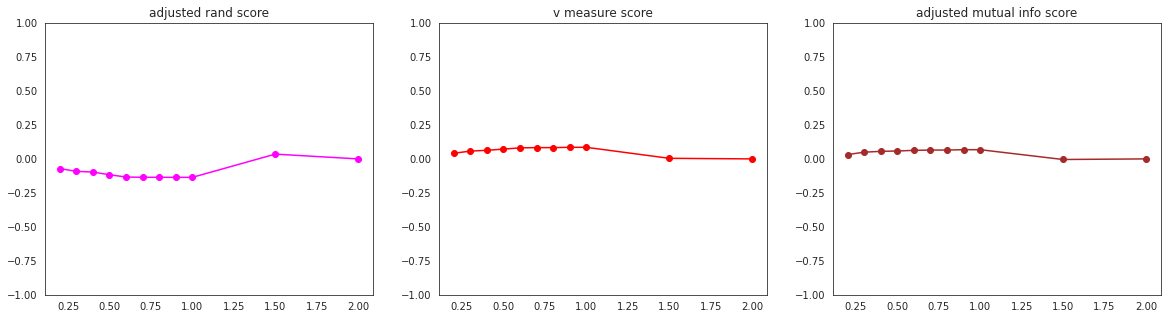

In [41]:
r = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9, 1, 1.5, 2]
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("homogeneity score")
plt.plot(r, metric_dict_dbs['homo'], marker='o', color='blue')
ax1.set_ylim([-1, 1])

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("completeness score")
plt.plot(r, metric_dict_dbs['comp'], marker='o', color='green')
ax2.set_ylim([-1, 1])

fig = plt.figure(figsize=(20, 5))
ax4 = plt.subplot(1, 3, 1)
ax4.set_title("adjusted rand score")
plt.plot(r, metric_dict_dbs['adj_rand'], marker='o', color='magenta')
ax4.set_ylim([-1, 1])

ax5 = plt.subplot(1, 3, 2)
ax5.set_title("v measure score")
plt.plot(r, metric_dict_dbs['v-meas'], marker='o', color="red")
ax5.set_ylim([-1, 1])

ax6 = plt.subplot(1, 3, 3)
ax6.set_title("adjusted mutual info score")
plt.plot(r, metric_dict_dbs['adj_mutual'], marker='o', color='brown')
ax6.set_ylim([-1, 1])

### Создание модели с оптимальными параметрами
Создаем модель, основанную на методе DBSCAN, с параметрами min_samples и eps, равными 2 и 1.5 соответственно, и выводим значения метрик.

In [42]:
dbs_model = DBSCAN(eps=1.50, min_samples=2)
dbs_model.fit(x)

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

In [43]:
hs_3 = metrics.homogeneity_score(y, dbs_model.labels_)
cs_3 = metrics.completeness_score(y, dbs_model.labels_)
ms_3 = metrics.v_measure_score(y, dbs_model.labels_)
ari_3 = metrics.adjusted_rand_score(y, dbs_model.labels_)
ami_3 = metrics.adjusted_mutual_info_score(y, dbs_model.labels_)
print(f"Homogeneity: {hs}")
print(f"Completeness: {cs}")
print(f"V-measure: {ms}")
print(f"Adjusted Rand-Index: {ari}")
print(f"Adjusted Mutual Info Score: {ami}")

Homogeneity: 0.2753898835921651
Completeness: 0.12770837631199072
V-measure: 0.17449638653694896
Adjusted Rand-Index: 0.1142178844499296
Adjusted Mutual Info Score: 0.16765842320020313


### Создание датафрейма со значениями меток кластеризатора
Создадим отдельный датафрейм, куда поместим значения меток, выставленные самим кластеризатором DBSCAN.

In [44]:
y1_dbs = pd.DataFrame(dbs_model.labels_)

### Визуализация полученных результатов с помощью алгоритма t-SNE
Построим два рисунка разбиения на кластеры - на одном цвета точек будут соответствовать классам, указанным в выборке, а на другом - выставленным кластеризатором.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 155 samples in 0.000s...
[t-SNE] Computed neighbors for 155 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 155 / 155
[t-SNE] Mean sigma: 0.898091
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.418049
[t-SNE] KL divergence after 1000 iterations: 0.427517


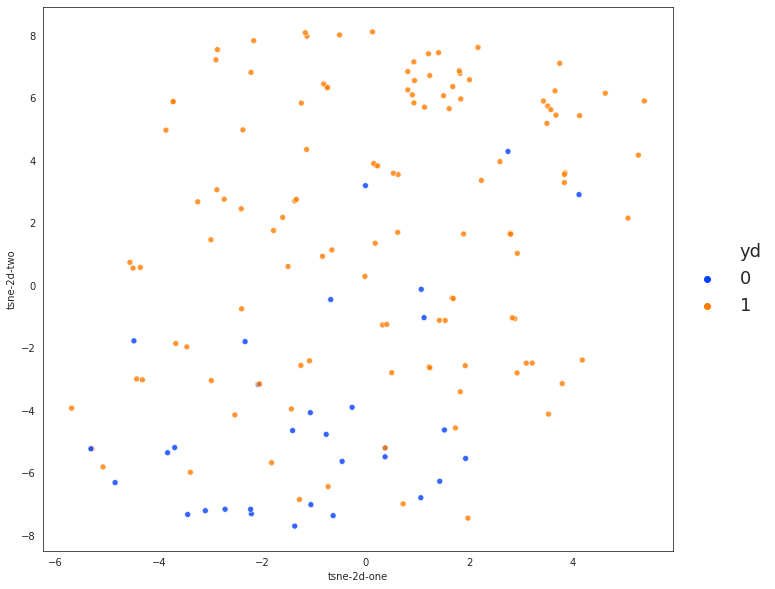

In [45]:
x_embedded_3 = TSNE(n_components=2, verbose=1, perplexity=40, 
                  early_exaggeration=12, metric='euclidean',
                 learning_rate=100, n_iter=2000).fit_transform(x)

x2_df = pd.DataFrame()
x2_df['tsne-2d-one'] = x_embedded_3[:,0]
x2_df['tsne-2d-two'] = x_embedded_3[:,1]
x2_df['yd'] = y.values
x2_df['y1'] = y1_dbs

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="yd", 
                palette=sns.color_palette("bright", 2), 
                data=x2_df, legend="full", alpha=0.8)
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

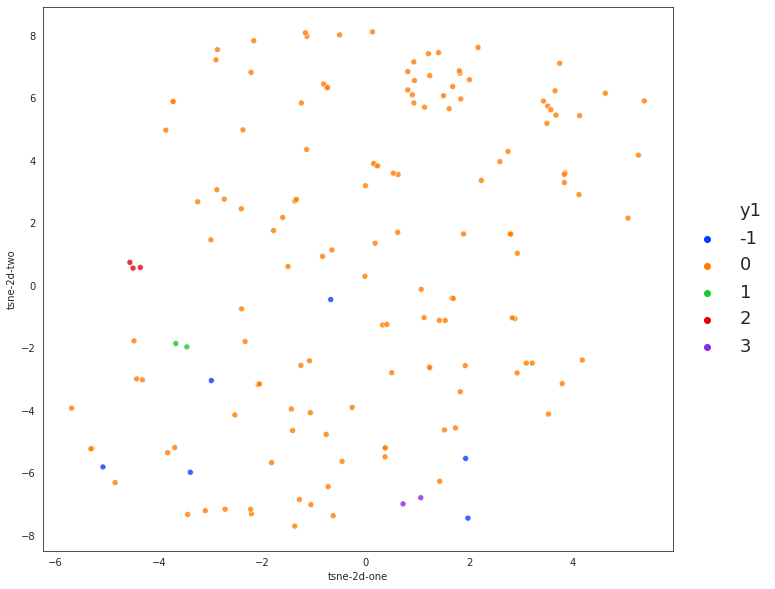

In [46]:
fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 5), 
                data=x2_df, legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

### Визуализация полученных результатов с помощью алгоритма UMAP
Так же как и с алгоритмом t-SNE, построим два рисунка разбиения на кластеры - на одном цвета точек будут соответствовать классам, указанным в выборке, а на другом - выставленным кластеризатором.

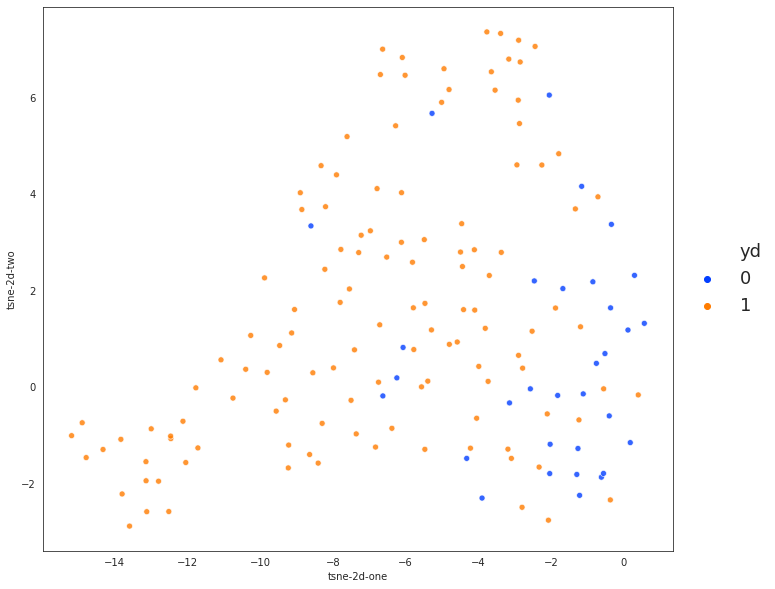

In [47]:
x_embedded_4 = umap.UMAP(n_neighbors=5, min_dist=0.8, metric='euclidean').fit_transform(x)
x2_df_1 = pd.DataFrame()
x2_df_1['tsne-2d-one'] = x_embedded_4[:, 0]
x2_df_1['tsne-2d-two'] = x_embedded_4[:, 1]
x2_df_1['yd'] = y.values
x2_df_1['y1'] = y1_dbs

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="yd", 
                palette=sns.color_palette("bright", 2), 
                data=x2_df_1,legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

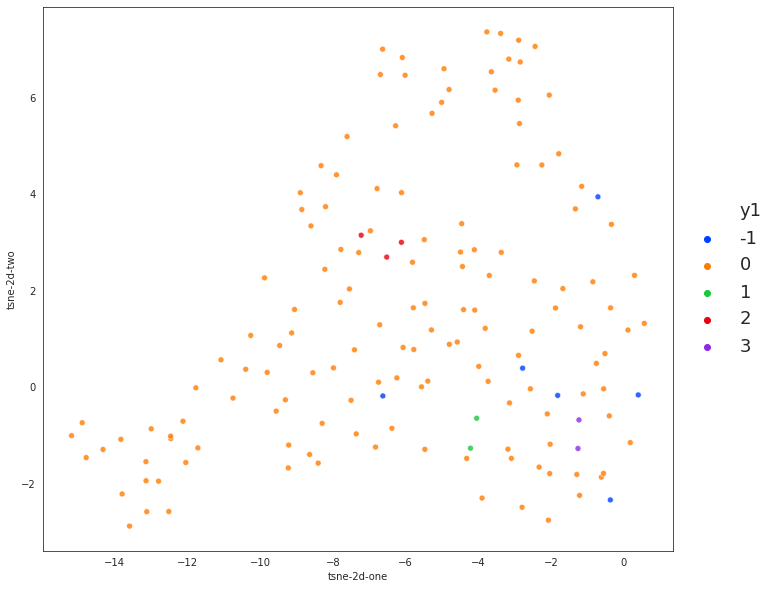

In [48]:
fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 5), 
                data=x2_df_1, legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 18})
plt.subplots_adjust(right=0.75)

## Сравнение результатов кластеризации
### Сравнение метрик оценки результатов кластеризации
Для начала выведем значения метрик оценки качества кластеризации, полученные при построении различных кластеризаторов:
* K-Means
* FCM с преобразованием исходных данных с помощью алгоритма t-SNE
* FCM с преобразованием исходных данных с помощью алгоритма UMAP
* DBSCAN

In [49]:
print(' ' * 10, '   K-Means\tFCM 1\tFCM 2\tDBSCAN')
print("Homogenity\t%0.3f" % hs, "\t%0.3f" % hs_1, "\t%0.3f" % hs_2, "\t%0.3f" % hs_3)
print("Completness\t%0.3f" % cs, "\t%0.3f" % cs_1, "\t%0.3f" % cs_2, "\t%0.3f" % cs_3)
print("Silhoette\t%0.3f" % ss, "\t%0.3f" % ss_1, "\t%0.3f" % ss_2)
print("V-measure\t%0.3f" % ms, "\t%0.3f" % ms_1, "\t%0.3f" % ms_2, "\t%0.3f" % ms_3)
print("ARI\t\t%0.3f" % ari, "\t%0.3f" % ari_1, "\t%0.3f" % ari_2, "\t%0.3f" % ari_3)
print("AMI\t\t%0.3f" % ami, "\t%0.3f" % ami_1, "\t%0.3f" % ami_2, "\t%0.3f" % ami_3)

              K-Means	FCM 1	FCM 2	DBSCAN
Homogenity	0.275 	0.182 	0.362 	0.023
Completness	0.128 	0.134 	0.104 	0.030
Silhoette	0.151 	0.179 	0.104
V-measure	0.174 	0.154 	0.162 	0.026
ARI		0.114 	0.131 	0.047 	0.010
AMI		0.168 	0.150 	0.149 	-0.007


In [50]:
hms = {'K-Means': 0.486, 'FCM 1': 0.414, 'FCM 2': 0.349, 'DBSCAN': 0.724}
cms = {'K-Means': 0.801, 'FCM 1': 0.836, 'FCM 2': 0.690, 'DBSCAN': 0.802}
sls = {'K-Means': 0.208, 'FCM 1': 0.159, 'FCM 2': 0.118, 'DBSCAN': 0.274}
vms = {'K-Means': 0.605, 'FCM 1': 0.554, 'FCM 2': 0.464, 'DBSCAN': 0.761}
aris = {'K-Means': 0.324, 'FCM 1': 0.279, 'FCM 2': 0.230, 'DBSCAN': 0.445}
amis = {'K-Means': 0.472, 'FCM 1': 0.405, 'FCM 2': 0.339, 'DBSCAN': 0.690}

### Построение столбчатых диаграмм со значениями метрик
Для визуализации полученных результатов построим столбчатые диаграммы для каждой метрики.

(0.0, 1.0)

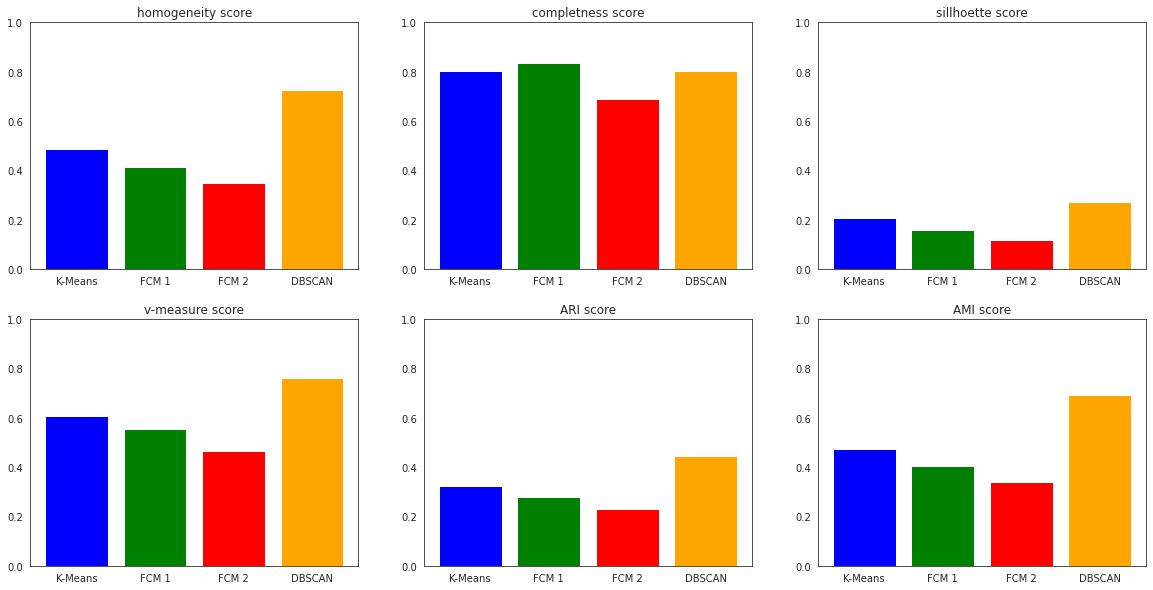

In [51]:
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 3, 1)
ax1.set_title("homogeneity score")
plt.bar(range(len(hms)), list(hms.values()), tick_label=list(hms.keys()), color=['blue', 'green', 'red', 'orange'])
ax1.set_ylim([0, 1])

ax2 = plt.subplot(2, 3, 2)
ax2.set_title("completness score")
plt.bar(range(len(cms)), list(cms.values()), tick_label=list(cms.keys()), color=['blue', 'green', 'red', 'orange'])
ax2.set_ylim([0, 1])

ax3 = plt.subplot(2, 3, 3)
ax3.set_title("sillhoette score")
plt.bar(range(len(sls)), list(sls.values()), tick_label=list(sls.keys()), color=['blue', 'green', 'red', 'orange'])
ax3.set_ylim([0, 1])

ax4 = plt.subplot(2, 3, 4)
ax4.set_title("v-measure score")
plt.bar(range(len(vms)), list(vms.values()), tick_label=list(vms.keys()), color=['blue', 'green', 'red', 'orange'])
ax4.set_ylim([0, 1])

ax5 = plt.subplot(2, 3, 5)
ax5.set_title("ARI score")
plt.bar(range(len(aris)), list(aris.values()), tick_label=list(aris.keys()), color=['blue', 'green', 'red', 'orange'])
ax5.set_ylim([0, 1])

ax6 = plt.subplot(2, 3, 6)
ax6.set_title("AMI score")
plt.bar(range(len(amis)), list(amis.values()), tick_label=list(amis.keys()), color=['blue', 'green', 'red', 'orange'])
ax6.set_ylim([0, 1])

### Сравнение визуализации результатов кластеризации (t-SNE)

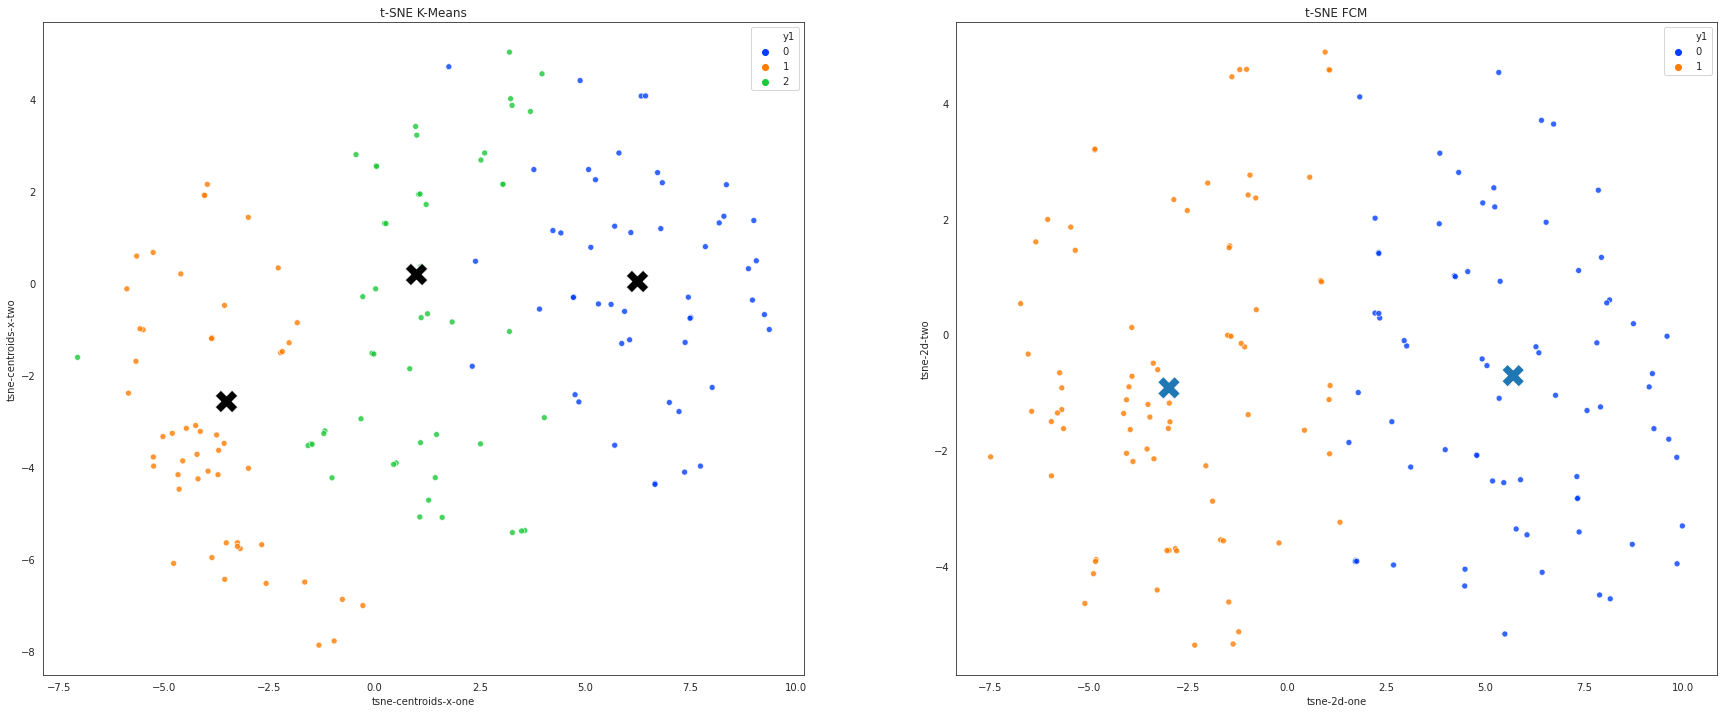

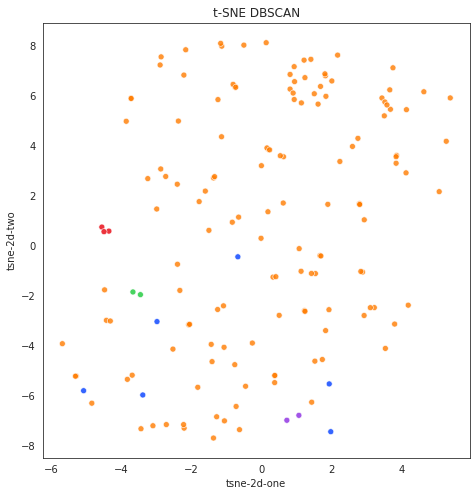

In [52]:
fig = plt.figure(figsize=(30, 12))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("t-SNE K-Means")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 3), 
                data=x1_df, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-centroids-x-one", y="tsne-centroids-x-two", 
                hue="tsne-centroids-y", data=c_df, legend=False, 
                alpha=1, marker='X', s=500, color='black')

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("t-SNE FCM")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 2), 
                data=x_df_1, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", 
                hue="yc", data=centers, legend=False, 
                alpha=1, marker='X', s=500, color='black')

fig1 = plt.figure(figsize=(26, 8))
ax3 = plt.subplot(1, 3, 3)
ax3.set_title("t-SNE DBSCAN")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 5), 
                data=x2_df, legend=False, alpha=0.8)

### Сравнение визуализации результатов кластеризации (UMAP)

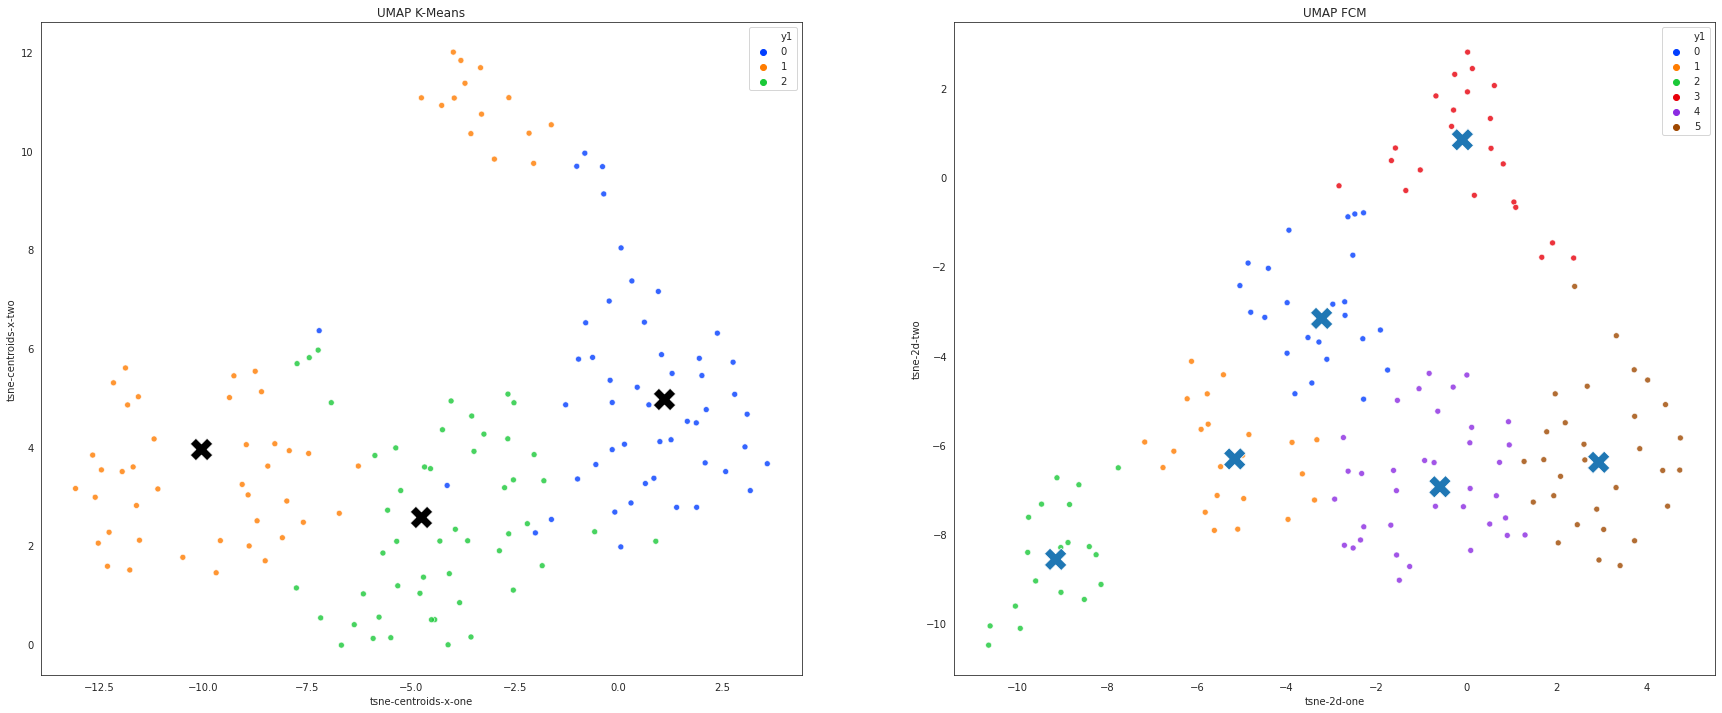

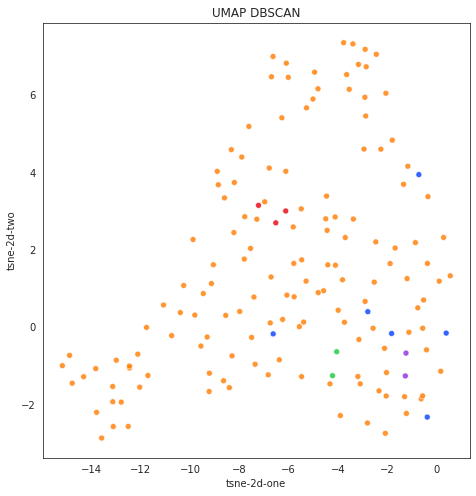

In [53]:
fig = plt.figure(figsize=(30, 12))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("UMAP K-Means")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 3), 
                data=x1_df_k, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-centroids-x-one", y="tsne-centroids-x-two", 
                hue="tsne-centroids-y", data=c_df_k, legend=False, 
                alpha=1, marker='X', s=500, color='black')

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("UMAP FCM")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 6), 
                data=x_df_2, legend="full", alpha=0.8)

sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", 
                hue="yc", data=centers_1, legend=False, 
                alpha=1, marker='X', s=500, color='black')

fig1 = plt.figure(figsize=(26, 8))
ax3 = plt.subplot(1, 3, 3)
ax3.set_title("UMAP DBSCAN")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y1", 
                palette=sns.color_palette("bright", 5), 
                data=x2_df_1, legend=False, alpha=0.8)

## Вывод
Сравнив полученные результаты, можно сделать вывод, что лучшим методом кластеризации для данного набора данных является алгоритм DBSCAN. Данный метод, оперируя информацией о плотности данных, разбил объекты на классы более подробно, чем в исходной выборке 5 классов против двух.  
Второе место занимает FCM (с преобразованием исходных данных с помощью t-SNE).
Третье место занимает K-means.
Хуже же всего показал себя метод FCM, оперирующий исходными данными, преобразованными с помощью алгоритма понижения размерности UMAP.